In [ ]:
!nvidia-smi

Sat Mar  5 17:06:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip3 install timm
!pip3 install torchio
!pip3 install omegaconf
!pip3 install mmcv

     |████████████████████████████████| 431 kB 4.9 MB/s 
     |████████████████████████████████| 164 kB 4.8 MB/s 
     |████████████████████████████████| 48.4 MB 2.1 MB/s 
     |████████████████████████████████| 74 kB 2.2 MB/s 
     |████████████████████████████████| 596 kB 10.8 MB/s 
     |████████████████████████████████| 112 kB 58.0 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=a826a8266750ce8944c42a0a6ffc9b5657b92314a18ce644c8c29f03ec457359
  Stored in directory: /root/.cache/pip/wheels/ca/33/b7/336836125fc9bb4ceaa4376d8abca10ca8bc84ddc824baea6c
Successfully built antlr4-python3-runtime
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


     |████████████████████████████████| 438 kB 5.2 MB/s 
     |████████████████████████████████| 190 kB 50.5 MB/s 
  Created wheel for mmcv: filename=mmcv-1.4.6-py2.py3-none-any.whl size=656045 sha256=1b00bbc7f40d2615d00da9acd88c41cba0bbe265e132d7afdb9d57ab8365d6bd
  Stored in directory: /root/.cache/pip/wheels/4b/dc/28/f5fdb35b7e1a5f50de1a95a49e5f661e4ffb10461d35974240
Successfully built mmcv


In [1]:
%cd '/content/drive/MyDrive/COViT++'
import os
import time
import random
import math
import torch
import numpy as np
from omegaconf import OmegaConf

import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

from model.linear_super import LinearSuper
from model.lrsa_super import AttentionSuper
from model.layernorm_super import LayerNormSuper
from model.embedding_super import OverlapPatchembedSuper

from model.tfm_encoder_super import TransformerEncoderLayer

from model.supernet import PVTSuper
from supernet_train.supernet_engine import engine

from dataloader_n_aug.dataloader import get_test_data

from utils.utils import *
from utils.metric import MetricTracker
from utils.flops import get_flops

/content/drive/MyDrive/COViT++
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


# SUPERNET

In [ ]:
torch.cuda.empty_cache()
engine()

# EVOLUTION

In [ ]:
cwd = os.getcwd()
config_file = 'config/config.yml'
model_config_file = 'config/model_cfg_evolution.yml'

metric_ftns = ['loss', 'acc']
train_metrics = MetricTracker(*[m for m in metric_ftns], mode='train')
valid_metrics = MetricTracker(*[m for m in metric_ftns], mode='validation')

config = OmegaConf.load((os.path.join(cwd, config_file)))['config']
model_cfg = OmegaConf.load((os.path.join(cwd, model_config_file)))

seeding(config)

In [ ]:
cudnn.benchmark = True

data_loader_val = get_test_data(config)

model = PVTSuper(img_size=model_cfg.input_size,
                                    super_embed_dims=[32, 64, 160, 256],\
                                    sample_embed_dims=model_cfg.SUPERNET.EMBED_DIMS,
                                    depths=model_cfg.SUPERNET.DEPTHS,
                                    mlp_ratios=model_cfg.SUPERNET.MLP_RATIOS,
                                    qkv_bias=True,
                                    drop_rate=model_cfg.drop_rate,
                                    attn_drop_rate=model_cfg.attn_drop_rate,
                                    num_classes=config.dataset.num_classes,
                                    num_stages=4)

choices = {'sample_pooling_dim': model_cfg.SEARCH_SPACE.SAMPLE_POOLING_DIM,
               'embed_dims': model_cfg.SEARCH_SPACE.EMBED_DIMS , 'depths': model_cfg.SEARCH_SPACE.DEPTHS}

Data collected! /content/drive/MyDrive/COViT++/data/test_split.txt


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
checkpoint_loader = torch.load(config.resume_training_dir, map_location='cpu')
checkpoint = model.state_dict()

for k, v in checkpoint_loader['model'].items():
    k = k.replace('module.', '')
    checkpoint.update({k: v})

model.load_state_dict(checkpoint, strict=True)

if not os.path.exists(config.resume_training):
    raise ("File doesn't exist {}".format(config.resume_training))

In [ ]:
torch.manual_seed(48)
np.random.seed(48)
random.seed(48)

if (config.cuda):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
else:
    device = torch.device("cpu")

model.to(device)

In [ ]:
from evo_search import EvolutionSearch

t = time.time()

searcher = EvolutionSearch(config=model_cfg, main_config=config, model=model, choices=choices, test_loader=data_loader_val)
searcher.search()

print('Total searching time = {:.2f} hours'.format((time.time() - t) / 3600))

# PARETO FRONT 
**Flops, Params., Acc. and COVID-19-Sens.** 

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


models_8844 = torch.load('/content/drive/MyDrive/COViT++/evo_output_dir/[8, 8, 4, 4]-checkpoint-100.pth')
models_8884 = torch.load('/content/drive/MyDrive/COViT++/evo_output_dir/[8, 8, 8, 4]-checkpoint-100.pth')

print('Number of 8-8-8-4 models: ', len(models_8884['vis_dict']))
print('Number of 8-8-4-4 models: ', len(models_8844['vis_dict']))

Number of 8-8-8-4 models:  393
Number of 8-8-4-4 models:  542


In [5]:
def preprocess_visdict(input_dict):
    visited_dicts = dict()

    for k, v in input_dict.items():
        if len(k) == 9 and all(key in v for key in ('params', 'test_acc', 'visited', 'flops (G)', 'covid_sens')):
            visited_dicts.update({k: v})
    return visited_dicts


def process_df(input_dict):
    input_dict = preprocess_visdict(input_dict)
    return pd.DataFrame(input_dict).transpose()


def top_test_acc(processed_df, spec_a=False, spec_b=False, spec_a_ascending=False, spec_b_ascending=False, sort_2_specs=False):
    if sort_2_specs:
        return processed_df.sort_values([spec_a, spec_b], ascending=[spec_a_ascending, spec_b_ascending]).head(20)
    else:
        return processed_df.sort_values(spec_a, ascending=spec_a_ascending).head(20)


def plot_pareto_frontier(Xs, Ys, ax, maxX=True, maxY=True, titleX='', titleY=''):
    # Pareto frontier selection process
    sorted_list = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxY)
    pareto_front = [sorted_list[0]]
    for pair in sorted_list[1:]:
        if maxY:
            if pair[1] >= pareto_front[-1][1]:
                pareto_front.append(pair)
        else:
            if pair[1] <= pareto_front[-1][1]:
                pareto_front.append(pair)
    
    # Plotting process
    ax.scatter(Xs, Ys)
    pf_X = [pair[0] for pair in pareto_front]
    pf_Y = [pair[1] for pair in pareto_front]
    ax.plot(pf_X, pf_Y, '-r', linewidth=4.0)
    ax.grid()

    ax.set_xlabel(titleX)
    ax.set_ylabel(titleY)


def plot_paretofront(processed_df):
    fig, axes = plt.subplots(2, 2, sharex=True, figsize=(10, 7))

    x = np.real(processed_df['params'])
    y = np.real(processed_df['flops (G)'])
    z = np.real(processed_df['test_acc'])
    t = np.real(processed_df['covid_sens'])

    plot_pareto_frontier(x, z, axes[0][0], maxX=False, maxY=True, titleX='params (M)', titleY='test_acc (%)')
    plot_pareto_frontier(y, z, axes[0][1], maxX=False, maxY=True, titleX='flops (G)', titleY='test_acc (%)')
    plot_pareto_frontier(x, t, axes[1][0], maxX=False, maxY=True, titleX='params (M)', titleY='covid_sens (%)')
    plot_pareto_frontier(y, t, axes[1][1], maxX=False, maxY=True, titleX='flops (G)', titleY='covid_sens (%)')

    fig.tight_layout()
    plt.show()

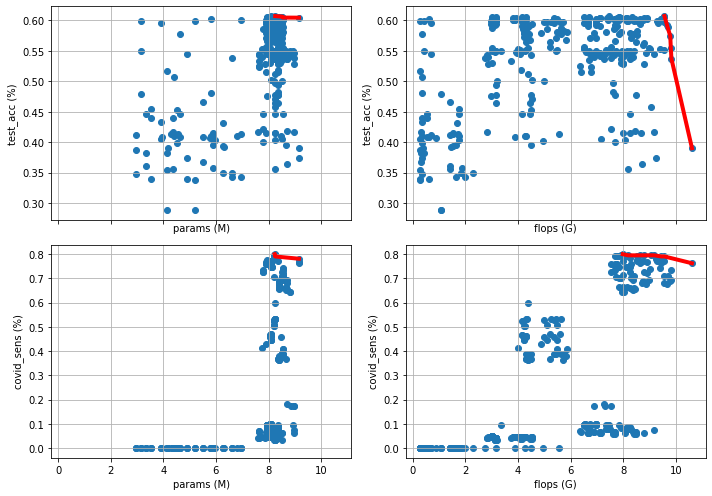

In [9]:
df_8884 = process_df(models_8884['vis_dict']).sort_values(['test_acc', 'covid_sens'], ascending=[False, False])

plot_paretofront(df_8884)

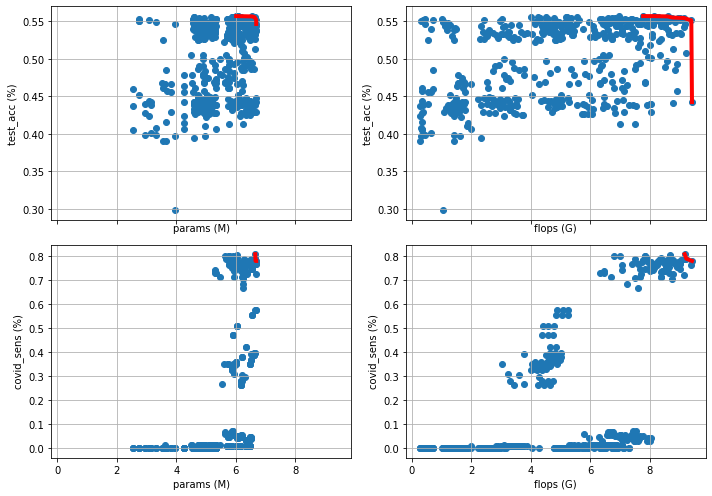

In [10]:
df_8844 = process_df(models_8844['vis_dict']).sort_values(['test_acc', 'covid_sens'], ascending=[False, False])

plot_paretofront(df_8844)

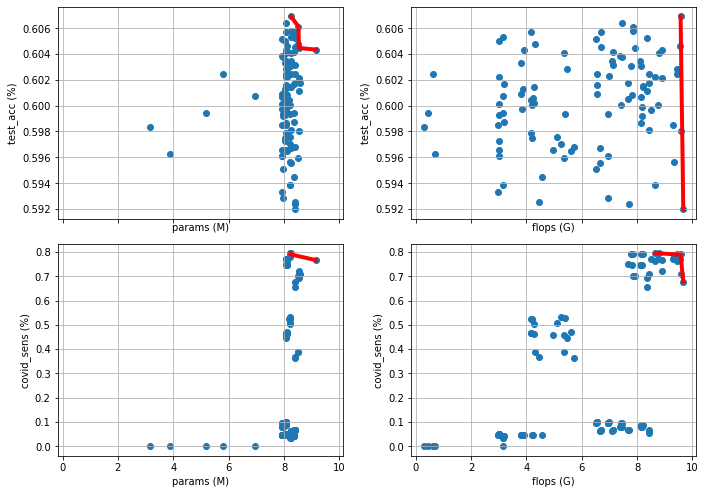

In [11]:
df_8884['8-8-8-4'] = True
df_8844['8-8-4-4'] = True

df_merged = pd.concat([df_8884, df_8844], ignore_index=False).fillna(False)[:100]

plot_paretofront(df_merged)

In [ ]:
top_test_acc(df_merged, spec_a='params', spec_b='test_acc', spec_a_ascending=True, spec_b_ascending=False, sort_2_specs=True)

params  test_acc  ...  8-8-8-4  8-8-4-4
7  2 2 2  2 16 32 80  128  3.161987  0.598342  ...     True    False
31 2 2 4  2 8  16 40  64   3.895987  0.596237  ...     True    False
15 2 3 6  2 16 32 80  128  5.198435  0.599429  ...     True    False
            32 64 160 256  5.799043  0.602453  ...     True    False
31 2 4 8  2 32 64 160 256  6.967939  0.600770  ...     True    False
     2 12 2 8  16 80  64   7.913747  0.600892  ...     True    False
7  2 2 12 2 8  16 80  64   7.913747  0.593286  ...     True    False
            24 16 80  64   7.917939  0.596571  ...     True    False
31 2 2 12 2 8  32 80  64   7.922035  0.599725  ...     True    False
7  2 2 12 2 8  32 80  64   7.922035  0.598503  ...     True    False
            24 32 80  64   7.926227  0.596133  ...     True    False
               48 80  64   7.934515  0.600125  ...     True    False
31 3 2 12 2 24 16 80  64   7.939035  0.600681  ...     True    False
7  3 2 12 2 24 16 80  64   7.939035  0.596062  ...     True    False
            8  32 80  64   7.941035  0.605191  ...     True    False
31 3 2 12 2 8  32 80  64   7.941035  0.603832  ...     True    False
7  3 2 12 2 24 32 80  64   7.947323  0.599346  ...     True    False
31 3 2 12 2 24 32 80  64   7.947323  0.599168  ...     True    False
            8  48 80  64   7.949323  0.603761  ...     True    False
7  3 2 12 2 8  48 80  64   7.949323  0.595089  ...     True    False

[20 rows x 7 columns]

In [ ]:
df_merged[(df_merged['params'] > 3.0) & (df_merged['params'] < 6.5)]

params  test_acc  ...  8-8-8-4  8-8-4-4
15 2 3 6 2 32 64 160 256  5.799043  0.602453  ...     True    False
           16 32 80  128  5.198435  0.599429  ...     True    False
7  2 2 2 2 16 32 80  128  3.161987  0.598342  ...     True    False
31 2 2 4 2 8  16 40  64   3.895987  0.596237  ...     True    False

[4 rows x 7 columns]


**Best model configuration:** 
(7,	2,	2,	2,	2,	16,	32,	80,	128)